<a href="https://colab.research.google.com/github/kjamithash/Pytorch_DeepLearning_Experiments/blob/master/FashionCNN_Fashion_MNSIT_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Fashion-MNSIT using a Convolutional Neural Network

## Imports

### Import standard PyTorch modules

In [0]:
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from torchvision import transforms
from torch.autograd import Variable


### Check PyTorch versions

In [58]:
# check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.4.0
0.5.0


## Data

### Transform definition

In [0]:
img_transforms = transforms.Compose([   
    transforms.ToTensor()
    ])

### Download the dataset

In [0]:
train_dataset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = img_transforms
)

test_dataset = torchvision.datasets.FashionMNIST(
                  root='./data/FashionMNIST',
                  train=False,
                  transform = img_transforms
)


### Plotting a subset of images

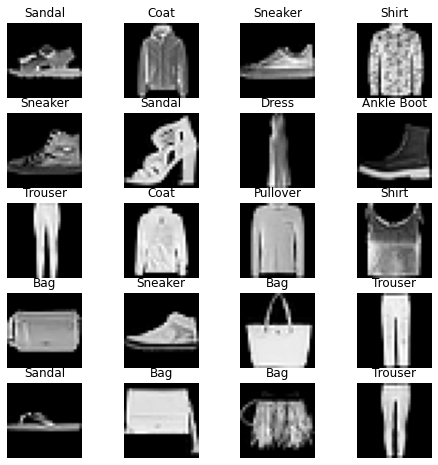

In [61]:
import matplotlib.pyplot as plt
import numpy as np

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
              
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()


### Setting up the dataloaders

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=100,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100,
                                          shuffle=False)

## Network

### Hyperparameters

In [0]:
num_classes   = 10    # The number of output classes. In this case, from 0 to 9
num_epochs    = 5     # The number of times entire dataset is trained
batch_size    = 100   # The size of input data took for one iteration
learning_rate = 1e-3  # The speed of convergence

### Model

![Model-Diagram](https://raw.githubusercontent.com/kjamithash/Pytorch_DeepLearning_Experiments/master/network.png)




In [0]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=7*7*32, out_features=10)

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        
        return out


### Copy model to GPU

In [65]:
model = FashionCNN()

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model.to(device)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

### The optimizer and loss

In [0]:
loss_fcn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training

In [67]:
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list_train = []
count_train = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
        images = Variable(images.view(100, 1, 28, 28))         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        labels = Variable(labels)
        
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = model(images)                           # Forward pass: compute the output class given a image
        loss = loss_fcn(outputs, labels)                  # Compute the loss: difference between the output class and the pre-given label
        loss_list.append(loss.data)                       # Add losses to buffer to viusalise later
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes

        count_train += 1
        iteration_list_train.append(count_train)  

        if (i+1) % 100 == 0:                              # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item()))
  

Epoch [1/5], Step [100/600], Loss: 0.5374
Epoch [1/5], Step [200/600], Loss: 0.3882
Epoch [1/5], Step [300/600], Loss: 0.3659
Epoch [1/5], Step [400/600], Loss: 0.3907
Epoch [1/5], Step [500/600], Loss: 0.3087
Epoch [1/5], Step [600/600], Loss: 0.2333
Epoch [2/5], Step [100/600], Loss: 0.4265
Epoch [2/5], Step [200/600], Loss: 0.4036
Epoch [2/5], Step [300/600], Loss: 0.2538
Epoch [2/5], Step [400/600], Loss: 0.2638
Epoch [2/5], Step [500/600], Loss: 0.2444
Epoch [2/5], Step [600/600], Loss: 0.2715
Epoch [3/5], Step [100/600], Loss: 0.3118
Epoch [3/5], Step [200/600], Loss: 0.3175
Epoch [3/5], Step [300/600], Loss: 0.2178
Epoch [3/5], Step [400/600], Loss: 0.2633
Epoch [3/5], Step [500/600], Loss: 0.2287
Epoch [3/5], Step [600/600], Loss: 0.2345
Epoch [4/5], Step [100/600], Loss: 0.1859
Epoch [4/5], Step [200/600], Loss: 0.2973
Epoch [4/5], Step [300/600], Loss: 0.2131
Epoch [4/5], Step [400/600], Loss: 0.3505
Epoch [4/5], Step [500/600], Loss: 0.1630
Epoch [4/5], Step [600/600], Loss:

### Testing


In [68]:
# Lists for knowing classwise accuracy
accuracy_list = []
iteration_list_test = []
count_test = 0

correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(100, 1, 28, 28))
    
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count

    count_test += 1
    iteration_list_test.append(count_test)  

    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)
    
print('Accuracy of the network on the test images: %d %%' %accuracy)

Accuracy of the network on the test images: 89 %


## Visualisation

### Visualising the results

The false predictions have their titles in red. 
The ground truth labels are written in brackets. 

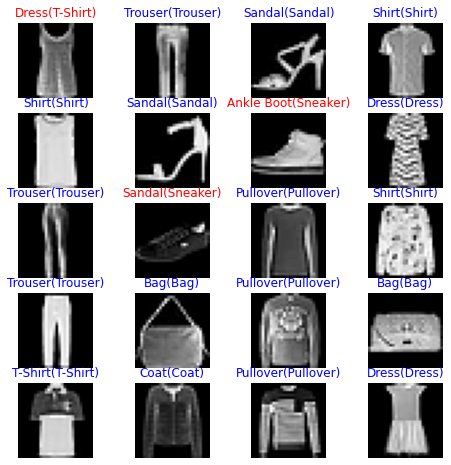

In [88]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
              
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model.to(device)

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(test_dataset));
    img = test_dataset[img_xy][0][0,:,:]
    gt_label = test_dataset[img_xy][1]
    
    if torch.cuda.is_available():
      img = img.cuda()
    
    input_image = Variable(img.view(1, 1, 28, 28))
    
    output_label = model(input_image)

    _, predicted_label = torch.max(output_label.data, 1)  # Choose the best class from the output: The class with the best score

    fig.add_subplot(rows, columns, i)
    title_obj = plt.title(str(labels_map[predicted_label.item()])+'('+str(labels_map[gt_label])+')')
    if gt_label == predicted_label.item():
      plt.setp(title_obj, color='b')    
    else:
      plt.setp(title_obj, color='r')    
    plt.axis('off')
    plt.imshow(img.cpu(), cmap='gray')
plt.show()


### Plotting the loss

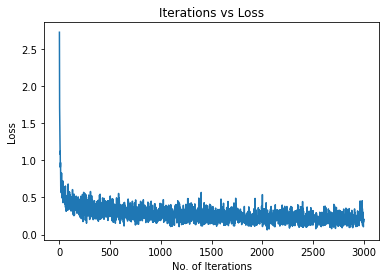

In [70]:
plt.plot(iteration_list_train, loss_list)
plt.xlabel("No. of Iterations")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

###Plotting the accuracy

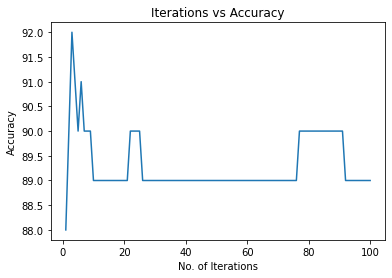

In [71]:
plt.plot(iteration_list_test, accuracy_list)
plt.xlabel("No. of Iterations")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

### Bonus: Visualising the filters

In a convolutional network, we let the network learn the filters that help it classify an image. We visualize the filters from the first layer and the second layer. 

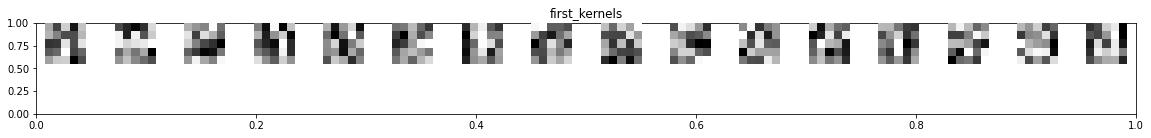

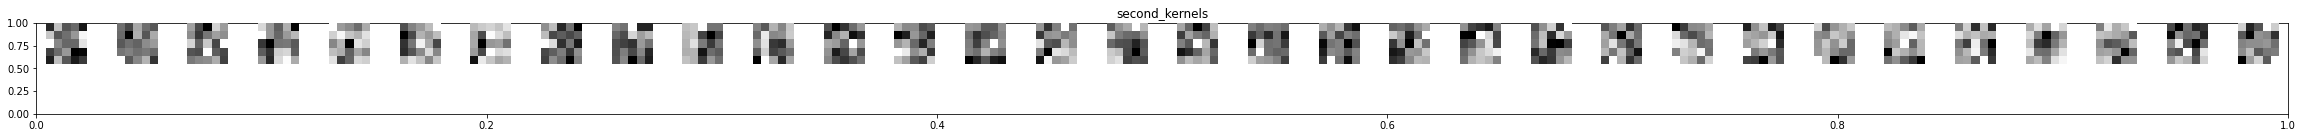

In [86]:
def plot_kernels(title, tensor, num_cols):
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    
    fig = plt.figure(figsize=(num_cols,num_rows))
    plt.title(title)
    
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i][0,:,:], cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.tight_layout()    
    plt.show()
  
model_layers = [i for i in model.children()];

first_layer = model_layers[0].cpu();
first_kernels = first_layer[0].weight.data.numpy()
plot_kernels("first_kernels",first_kernels, 16)

second_layer = model_layers[1].cpu();
second_kernels = second_layer[0].weight.data.numpy()
plot_kernels("second_kernels",second_kernels, 32)



### Saving models

In [87]:
torch.save(model.state_dict(), "/tmp/FashionCNN")    
model = FashionCNN()
model_state_dict = torch.load("/tmp/FashionCNN")
model.load_state_dict(model_state_dict)

<All keys matched successfully>